In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Ntrain = train_input_100.size(0)
Ntest = test_input_100.size(0)
Nchannels = train_input_100.size(1)
Nsamples_100 = train_input_100.size(-1)
Nsamples_1000 = train_input_1000.size(-1)

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Data Augementation & Data Preprocessing

In [3]:
def preprocessing_train(train_input):
    #denoise and normalize data (without detrending and so)
    tmp = np.array(train_input)
    #tmp = denoisedSignals(tmp)

    #we take the 1000 hz signal and we subsample it with different time steps we downsample to 100Hz but with different initial points. By ding so we have 10 times more samples instead of having ones big weigth for the 1000hz sample

    augemented_train_input = tmp[:,:,0::10]

    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,1::10]))
    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,2::10]))
    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,3::10]))
    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,4::10]))
    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,5::10]))
    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,6::10]))
    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,7::10]))
    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,8::10]))
    augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,9::10])) #100 subsampled terms 

    '''noise_tensor = np.zeros(augemented_train_input.shape)

    for i in range (augemented_train_input.shape[0]):
        noiseIntensity = 0.1*np.max(augemented_train_input[i,:,:])
        noise_tensor[i , :, :] = noise(augemented_train_input[i,:,:], noiseIntensity)
    
    return noise_tensor'''
    return augemented_train_input

def preprocessing_test(test_input):
    #denoise and normalize data (without detrending and so)
    tmp = np.array(test_input)
    #tmp = denoisedSignals(tmp)

    #we take the 1000 hz signal and we subsample it with different time steps we downsample to 100Hz but with different initial points. By ding so we have 10 times more samples instead of having ones big weigth for the 1000hz sample
    return tmp

# For debugging purposes

In [4]:
batch_size = 11
Nchannels = 28
Nsamples = 50
x = Tensor(batch_size, Nchannels, Nsamples, 1).normal_()

In [5]:
# Layer 1
l1_channels = 16  
conv1 = nn.Conv2d(1, l1_channels, (Nchannels, 1), padding = 0)
batchnorm1 = nn.BatchNorm2d(l1_channels, False) # final size bsize x 1 x l1_channels x Nsamples

# Layer 2
l2_channels = 4
l2_temp_window = 32
l2_l1channel_overlap = 2
padding1 = nn.ZeroPad2d((l2_temp_window // 2, l2_temp_window // 2 - 1, l2_l1channel_overlap//2-1, l2_l1channel_overlap//2)) # left, right, top, bottom
conv2 = nn.Conv2d(1, l2_channels, (l2_l1channel_overlap, l2_temp_window))  # does not change size if combined with above padding
batchnorm2 = nn.BatchNorm2d(l2_channels, False)
pooling2 = nn.MaxPool2d((2, 4)) # final size bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

# Layer 3
l3_channels = 4
l3_temp_window = 4
l3_l2channel_overlap = 8
padding2 = nn.ZeroPad2d((l3_temp_window//2, l3_temp_window//2-1, l3_l2channel_overlap//2, l3_l2channel_overlap//2-1))
conv3 = nn.Conv2d(l2_channels, l3_channels, (l3_l2channel_overlap, l3_temp_window))
batchnorm3 = nn.BatchNorm2d(l3_channels, False)
pooling3 = nn.MaxPool2d((2, 4)) # final size bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

# FC Layer
fc_inputs = l3_channels * (l1_channels//4) * (Nsamples//16)
fc1 = nn.Linear(fc_inputs, 1)

# Forward pass: input size= (bsize,Nchannels, Nsamples, 1)
x = Variable(x)
x = x.permute(0, 3, 1, 2)   # bsize x 1 x Nchannels x Nsamples
# Layer 1
x = F.relu(conv1(x))         # bsize x l1_channels x 1 x Nsamples
x = batchnorm1(x)
x = F.dropout(x, 0.25)
x = x.permute(0, 2, 1, 3)   # bsize x 1 x l1_channels x Nsamples
print("Layer 1 output has size: ", x.shape)
# Layer 2
x = padding1(x)
x = F.relu(conv2(x))    # bsize x l2_channels x l1_channels x Nsamples
x = batchnorm2(x)       
x = F.dropout(x, 0.25)
x = pooling2(x)             # bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)
print("Layer 2 output has size:", x.shape)
# Layer 3
x = padding2(x)
x = F.relu(conv3(x))         # bsize x l3_channels x floor(l1_channels/2) x floor(Nsamples/4)
x = batchnorm3(x)
x = F.dropout(x, 0.25)
x = pooling3(x)             # bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)
print("Layer 3 output has size:", x.shape)
# FC Layer
x = x.view(-1, fc_inputs)   # bsize x (l3_channels*floor(l1_channels/4)*floor(Nsamples/16))
x = F.sigmoid(fc1(x))
print("Network output has size:", x.shape)

Layer 1 output has size:  torch.Size([11, 1, 16, 50])
Layer 2 output has size: torch.Size([11, 4, 8, 12])
Layer 3 output has size: torch.Size([11, 4, 4, 3])
Network output has size: torch.Size([11, 1])


# Network definition

In [6]:
class conv2DNet(nn.Module):
    
    def __init__(self, Nchannels, Nsamples, output_units):
        """Initializes neural network with 3 convolutional layers and 1 fully-connected layer.
        
        Args:
            - Nchannels (int): number of EEG channels
            - Nsamples (int): number of time points in each EEG signal
            - output_units (int): number of output units, e.g. 1 for training with loss torch.nn.BCELoss or 2 with 
            loss torch.nn.CrossEntropyLoss            
            
            """
        super(conv2DNet, self).__init__()
        # Layer 1
        l1_channels = 16  
        self.conv1 = nn.Conv2d(1, l1_channels, (Nchannels, 1), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(l1_channels, False) # final size bsize x 1 x l1_channels x Nsamples

        # Layer 2
        l2_channels = 4
        l2_temp_window = 32
        l2_l1channel_overlap = 2
        self.padding1 = nn.ZeroPad2d((l2_temp_window // 2, l2_temp_window // 2 - 1, l2_l1channel_overlap//2-1, l2_l1channel_overlap//2)) # left, right, top, bottom
        self.conv2 = nn.Conv2d(1, l2_channels, (l2_l1channel_overlap, l2_temp_window))  # does not change size if combined with above padding
        self.batchnorm2 = nn.BatchNorm2d(l2_channels, False)
        self.pooling2 = nn.MaxPool2d((2, 4)) # final size bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

        # Layer 3
        l3_channels = 4
        l3_temp_window = 4
        l3_l2channel_overlap = 8
        self.padding2 = nn.ZeroPad2d((l3_temp_window//2, l3_temp_window//2-1, l3_l2channel_overlap//2, l3_l2channel_overlap//2-1))
        self.conv3 = nn.Conv2d(l2_channels, l3_channels, (l3_l2channel_overlap, l3_temp_window))
        self.batchnorm3 = nn.BatchNorm2d(l3_channels, False)
        self.pooling3 = nn.MaxPool2d((2, 4)) # final size bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

        # FC Layer
        fc_inputs = l3_channels * (l1_channels//4) * (Nsamples//16)
        self.fc1 = nn.Linear(fc_inputs, output_units)
        
        
    def forward(self, x):
        """Applies forward pass consisting of 3 convolutional layers followed by a fully-connected linear layer.
        
        Args:
            - x (torch.autograd.Variable): the input batch. It has dimension batch_size x Nchannel x Nsamples x 1,
            where Nchannel is the number of EEG channels and Nsamples the number of time points.
        
        Returns:
            - (torch.autograd.Variable) of size either batch_size x output_units   
        
        """
        x = x.permute(0, 3, 1, 2)             # bsize x 1 x Nchannels x Nsamples
        
        # Layer 1
        x = F.elu(self.conv1(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.3)
        x = x.permute(0, 2, 1, 3)             # bsize x 1 x l1_channels x Nsamples

        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))              # bsize x l2_channels x l1_channels x Nsamples
        x = self.batchnorm2(x)       
        x = F.dropout(x, 0.3)
        x = self.pooling2(x)                  # bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))              # bsize x l3_channels x floor(l1_channels/2) x floor(Nsamples/4)
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.3)
        x = self.pooling3(x)                  # bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

        # Fully-connected Layer
        x = x.view(-1, self.fc1.in_features)  # bsize x (l3_channels*floor(l1_channels/4)*floor(Nsamples/16))
        x = F.sigmoid(self.fc1(x))            # bisze x self.fc1.out_features  
        
        if self.fc1.out_features == 1:
            x = x.view(-1)                     # bsize (1D if 1 output unit)
        
        return x

def compute_nb_errors(model, data_input, data_target):
    batch_size = 35  # not as crucial as in training. Just a matter of memory.
    nb_errors = 0
    Ndata = data_input.size(0)
    for b_start in range(0, data_input.size(0), batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [7]:
import torch.optim as optim
import math
import numpy as np
from utility import * 

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train(train_input_1000, train_target_1000, False, False)
preprocessed_input_test = preprocessing_test(test_input_100, False)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = test_target_100
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])
print(Ntrain)

train_input = Variable(preprocessed_input_train.view(Ntrain, Nchannels, Nsamples_100, 1))
test_input = Variable(test_input_100.view(Ntest, Nchannels, Nsamples_100, 1))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, Nchannels, Nsamples_100, 1))
print(validation_input.shape)

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

if isinstance(criterion, nn.BCELoss):
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float())
    test_target = Variable(labels_test.float())
    Noutputs = 1

elif isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    test_target = Variable(labels_test)
    validation_target = Variable(labels_validation)
    Noutputs = 2
        
model = conv2DNet(Nchannels, Nsamples_100, Noutputs)
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.90, nesterov=False)
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
batch_size = 40
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
Nrep = 1
train_errors = torch.Tensor(Nepochs).zero_()
test_errors = torch.Tensor(Nepochs).zero_()
valid_errors = torch.Tensor(Nepochs).zero_()
ep_loss = torch.Tensor(Nepochs).zero_()

for i_rep in range(Nrep):
    for i_ep in range(2, Nepochs):
        changeLearningRate = False
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))
            ep_loss[i_ep] += batch_loss.data[0]
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        nb_train_errs = compute_nb_errors(model, train_input, train_target)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target) #!!!!!!!!!!!!!!!!
        #nb_validation_errs = compute_nb_errors(model, test_input, test_target)
        
        train_errors[i_ep] = nb_train_errs
        valid_errors[i_ep] = nb_validation_errs
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) #!!!!!!!!!!!!!!!!
        #print("\t Validation accuracy ",(100*(Ntest-nb_validation_errs)/Ntest))
        
        if i_ep > 30:
            print((np.abs(ep_loss[i_ep] - ep_loss[i_ep-1])+np.abs(ep_loss[i_ep-1] - ep_loss[i_ep-2])+np.abs(ep_loss[i_ep-2] - ep_loss[i_ep-3])+np.abs(ep_loss[i_ep-3] - ep_loss[i_ep-4])))
            changeLearningRate = True
            
            #decrease the learning rate
            if(changeLearningRate):
                optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.90, nesterov=False)
                print("New Learning Rate")
                changeLearningRate = False                
       
    # Evaluate on test data
    nb_test_errs = compute_nb_errors(model, test_input, test_target)
    print("\n Train accuracy {} Test accuracy {}".format((Ntrain-nb_train_errs)/Ntrain, (Ntest-nb_test_errs)/Ntest))    

train (2710, 28, 50)
test (100, 28, 50)
validation (144, 28, 50)
2710
torch.Size([144, 28, 50, 1])
Epoch Number :  2
	 Training accuracy:  78.22878228782288
	 Validation accuracy  76.38888888888889
Epoch Number :  3
	 Training accuracy:  78.4870848708487
	 Validation accuracy  75.0
Epoch Number :  4
	 Training accuracy:  84.4649446494465
	 Validation accuracy  81.94444444444444
Epoch Number :  5
	 Training accuracy:  87.67527675276753
	 Validation accuracy  84.02777777777777
Epoch Number :  6
	 Training accuracy:  90.44280442804428
	 Validation accuracy  85.41666666666667
Epoch Number :  7
	 Training accuracy:  91.40221402214023
	 Validation accuracy  88.19444444444444
Epoch Number :  8
	 Training accuracy:  87.60147601476015
	 Validation accuracy  84.72222222222223
Epoch Number :  9
	 Training accuracy:  96.05166051660517
	 Validation accuracy  88.88888888888889
Epoch Number :  10
	 Training accuracy:  99.00369003690037
	 Validation accuracy  95.13888888888889
Epoch Number :  11
	 Tra

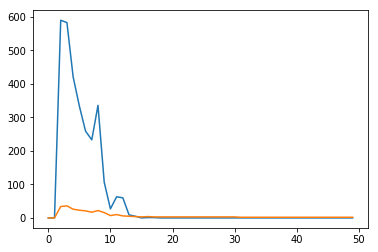

In [8]:
plt.plot(np.array(train_errors))
plt.plot(np.array(valid_errors))
plt.show()

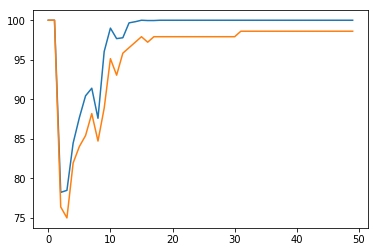

In [9]:
plt.plot(100*(Ntrain-np.array(train_errors))/Ntrain)
plt.plot(100*(Nvalidation-np.array(valid_errors))/Nvalidation)
plt.show()